In [1]:
suppressMessages(library(ArchR))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(harmony))
suppressMessages(library(dplyr))
suppressMessages(library(cowplot))
suppressMessages(library(harmony))
suppressMessages(library(Nebulosa))
suppressMessages(library(ggpubr))
suppressMessages(library(Ipaper))
suppressMessages(library(viridis))
suppressMessages(library(phateR))
suppressMessages(library(igraph))
suppressMessages(library(ggraph))
suppressMessages(library(tidygraph))
suppressMessages(library(patchwork))

In [2]:
coembed <- readRDS("../../../../IntegrativeAnalysis/Fibroblast/data/coembed/coembed.annotation.Rds")
coembed

An object of class Seurat 
221802 features across 43563 samples within 3 assays 
Active assay: RNA (28933 features, 2000 variable features)
 2 other assays present: peaks, GeneActivity
 7 dimensional reductions calculated: pca, umap, harmony, umap_harmony, umap_harmony_v2, phate, dm

In [3]:
df_count <- coembed@meta.data %>%
    as.data.frame() %>%
    group_by(annotation, tech) %>%
    summarise(count = n())

df_count

write.csv(df_count, "df_count_fibroblasts.csv")

`summarise()` has grouped output by 'annotation'. You can override using the
`.groups` argument.


annotation,tech,count
<fct>,<chr>,<int>
Fib_0,ATAC,2119
Fib_0,RNA,13779
Myofib,ATAC,1996
Myofib,RNA,13232
Fib_SCARA5,ATAC,708
Fib_SCARA5,RNA,6776
Fib_3,ATAC,826
Fib_3,RNA,4127


Fib1      Fib2      Fib3      Fib4 
"#D51F26" "#272E6A" "#208A42" "#89288F"

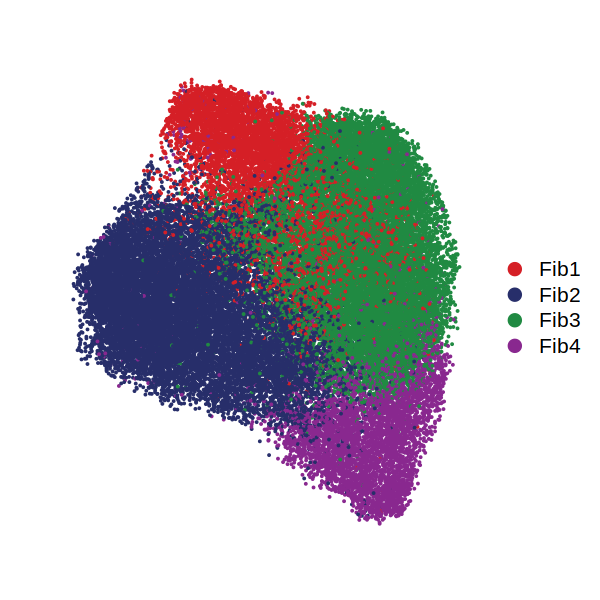

In [4]:
options(repr.plot.height = 5, repr.plot.width = 6)

coembed$annotation <- stringr::str_replace_all(coembed$annotation,
                                           c("Fib_SCARA5" = "Fib1",
                                            "Myofib" = "Fib2",
                                            "Fib_3" = "Fib4",
                                            "Fib_0" = "Fib3"))

coembed$annotation <- factor(coembed$annotation, 
                             levels = c("Fib1", "Fib2", "Fib3", "Fib4"))

cols <- ArchR::paletteDiscrete(unique(coembed$annotation))

cols

p1 <- DimPlot(coembed, reduction = "umap_harmony_v2", group.by = "annotation",
             cols = cols) +
    xlab("") + ylab("") + ggtitle("") +
    theme(axis.ticks = element_blank(),
         axis.text = element_blank(),
         axis.line = element_blank())

options(repr.plot.width = 5, repr.plot.height = 5)
p1

ggsave("fibroblast_umap_subclustering.pdf", plot=p1, height = 5, width = 5)

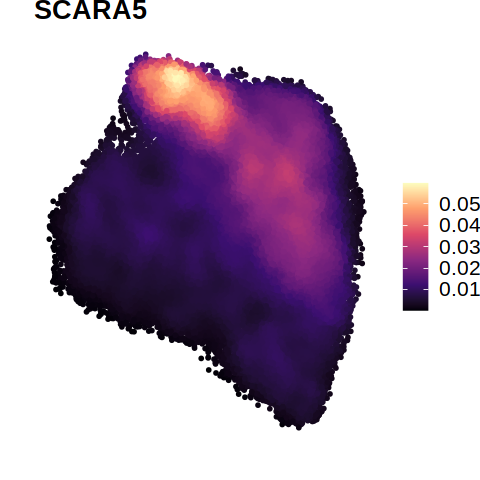

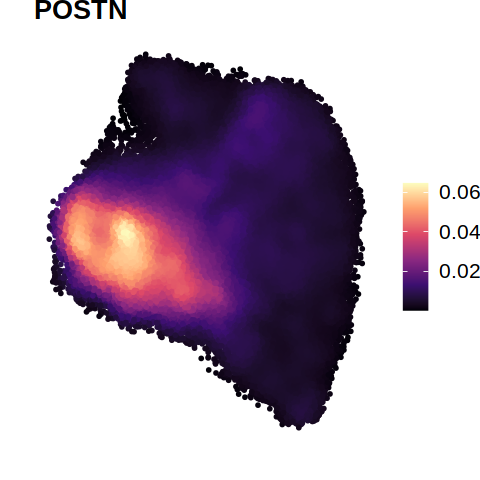

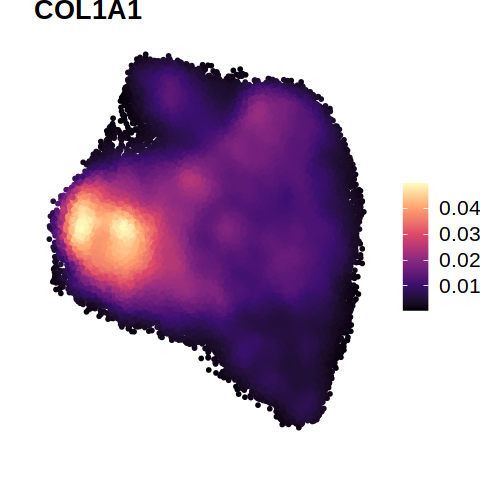

[[1]]
marker_SCARA5.pdf

[[2]]
marker_POSTN.pdf

[[3]]
marker_COL1A1.pdf

[[4]]
marker_FN1.pdf

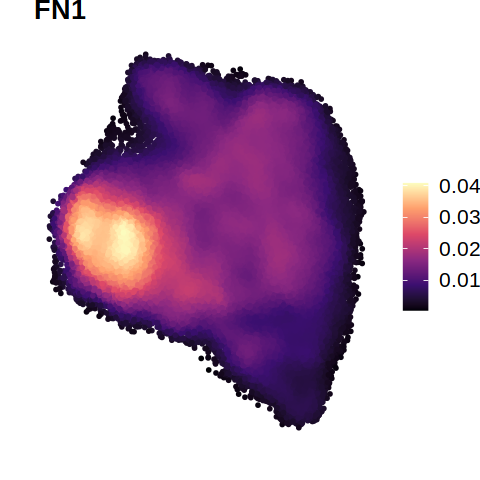

In [4]:
## plot markers
options(repr.plot.width = 4, repr.plot.height = 4)

gene.list <- c("SCARA5", "POSTN", "COL1A1", "FN1")

lapply(gene.list, function(gene){
    p <- plot_density(coembed, features = gene, reduction = "umap_harmony_v2",
                     pal = "magma") +
        xlab("") + ylab("") + ggtitle("") +
    theme_cowplot() +
    ggtitle(gene) +
    theme(axis.line = element_blank(),
         axis.ticks = element_blank(),
         axis.text = element_blank(),
         legend.title = element_blank(),
         plot.margin = unit(c(0, 0, 0, 0), "cm"))
    
    print(p)
    
    ggsave(glue::glue("marker_{gene}.pdf"), plot = p, height = 4, width = 4)
    
})


`summarise()` has grouped output by 'patient_region_id'. You can override using
the `.groups` argument.


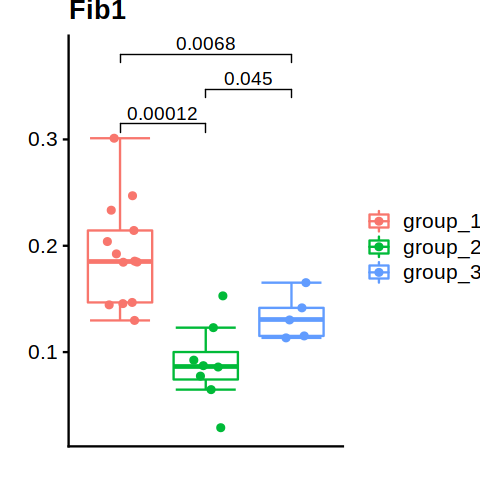

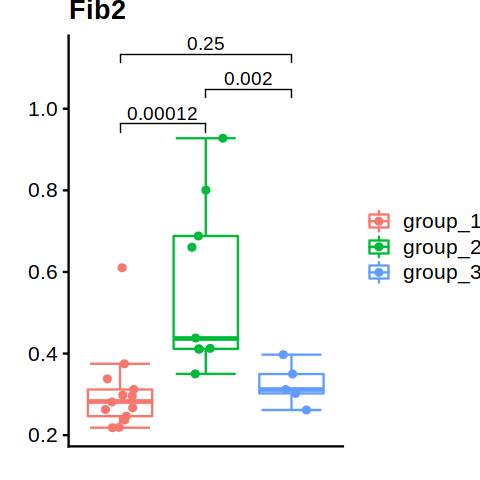

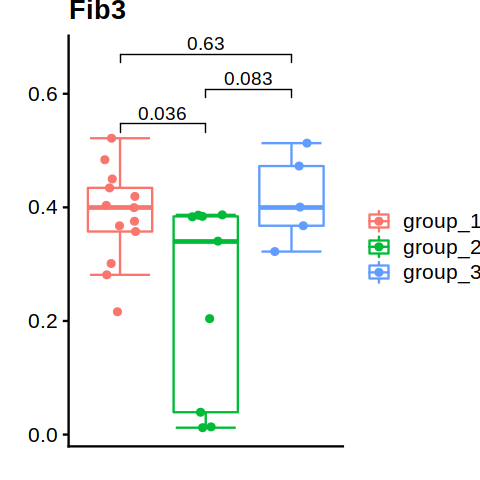

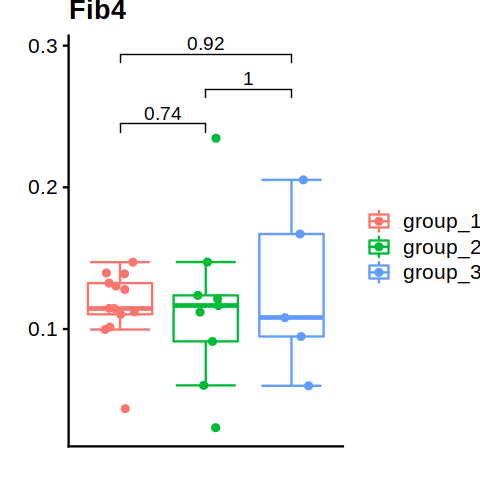

In [5]:
## we here update the annotaiton of samples
meta.data <- as.data.frame(coembed@meta.data) %>%
    rename(sample_id = orig.ident) %>%
    select(c(sample_id, annotation))

df_atac_anno <- read.csv("../../../../Annotations_figures/atac_patient_anns_revisions.csv")
df_rna_anno <- read.csv("../../../../Annotations_figures/rna_patient_anns_revisions.csv")

df_anno <- rbind(df_atac_anno, df_rna_anno) %>%
    select(c(sample_id, patient, patient_region_id, patient_group)) %>%
    subset(sample_id %in% meta.data$sample_id)

meta.data <- meta.data %>%
    dplyr::full_join(df_anno, by = "sample_id")

df_plot <- meta.data %>%
    group_by(patient_region_id, annotation) %>%
    summarise(counts = n()) %>%
    mutate(proportion = counts / sum(counts))

df_anno <- meta.data %>%
    subset(., select = c("patient_region_id", "patient_group")) %>%
    unique()

df_plot <- merge.data.frame(df_plot, df_anno)

options(repr.plot.width = 4, repr.plot.height = 4)

for(anno in unique(df_plot$annotation)){
    p <- df_plot %>%
        subset(annotation == anno) %>%
        ggplot(aes(x = patient_group, y = proportion)) +
        geom_boxplot2(aes(color = patient_group)) +
        geom_point(aes(color = patient_group), position = position_jitterdodge(), size = 1.5) +
        stat_compare_means(comparisons = list(c("group_1", "group_2"),
                                             c("group_2", "group_3"),
                                             c("group_1", "group_3")),
                       method = "wilcox.test"
                          #label.y = c(0.6, 0.65, 0.7),
                          ) +
        ggtitle(anno) +
        theme_cowplot() +
        #ylim(0, 0.75) +
        xlab("") + ylab("") +
        theme(axis.text.x = element_blank(),
             legend.title = element_blank(),
             axis.ticks.x = element_blank(),
             plot.margin = unit(c(0, 0, 0, 0), "cm")
             )
    
    print(p)
    
    ggsave(glue::glue("{anno}_with_p_value.pdf"), plot = p, height = 4, width = 4)

}

In [ ]:
# meta.data <- as.data.frame(coembed@meta.data)

# meta.data$patient_group <- stringr::str_replace_all(meta.data$patient_group,
#                                                    c("group_1" = "myogenic",
#                                                     "group_2" = "ischemic",
#                                                     "group_3" = "fibrotic"))

# meta.data$patient_group <- factor(meta.data$patient_group, levels = c("myogenic",
#                                                                      "ischemic",
#                                                                      "fibrotic"))

# df_plot <- meta.data %>% 
#             group_by(patient_region_id, annotation) %>%
#             summarise(counts = n()) %>%
#             mutate(proportion = counts / sum(counts))

# df_anno <- meta.data %>%
#     subset(., select = c("patient_region_id", "patient_group")) %>%
#     unique()

# df_plot <- merge.data.frame(df_plot, df_anno) %>%
#     subset(annotation %in% c("Fib1", "Fib2"))

# options(repr.plot.width = 2.5, repr.plot.height = 4)

# for(anno in unique(df_plot$annotation)){
#     p <- df_plot %>%
#         subset(annotation == anno) %>%
#         ggplot(aes(x = patient_group, y = proportion)) +
#         geom_boxplot2(aes(color = patient_group)) +
#         geom_point(aes(color = patient_group), 
#                    position = position_jitterdodge(), 
#                    size = 1.5) +
#         stat_compare_means(comparisons = list(c("myogenic", "ischemic"),
#                                              c("ischemic", "fibrotic"),
#                                              c("myogenic", "fibrotic")),
#                        method = "wilcox.test"
#                           #label.y = c(0.6, 0.65, 0.7)
#                           ) +
#         ggtitle(anno) +
#         theme_cowplot() +
#         #ylim(0, 0.75) +
#         xlab("") + ylab("") +
#         theme(axis.text.x = element_text(angle = 90, hjust = 1),
#              legend.title = element_blank(),
#              plot.margin = unit(c(0, 0, 0, 0), "cm"),
#               legend.position = "none"
#              )
    
#     print(p)
    
#     ggsave(glue::glue("{anno}_with_p_value.pdf"), plot = p, height = 4, width = 2.5)

# }

In [6]:
## spatial transcriptimics data
obj <- readRDS("../../../../visiumSpatial/from_rico/processed_visium/objects/Visium_5_CK283.rds")

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



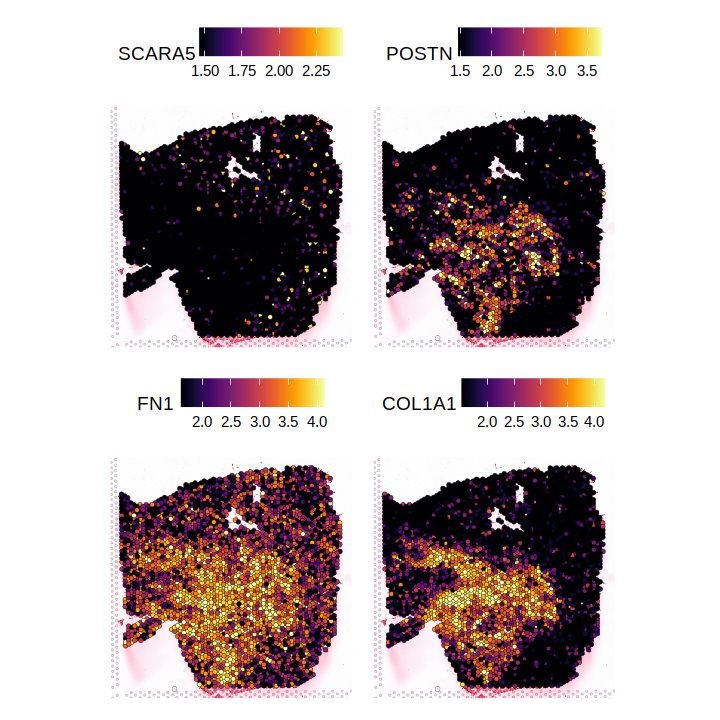

In [7]:
DefaultAssay(obj) <- "SCT"

plotlist <- SpatialFeaturePlot(obj, features = c("SCARA5", "POSTN",
                                                        "FN1", "COL1A1"), 
                                       combine = FALSE, min.cutoff = "q5", max.cutoff = "q95")
    
plotlist <- lapply(1:length(plotlist), function(i){
          p <- plotlist[[i]] +
           scale_fill_viridis(option = "B")
          return(p)
        })

p <- patchwork::wrap_plots(plotlist, nrow = 2)

options(repr.plot.height = 6, repr.plot.width = 6)

p

ggsave("Visium_5_marker.pdf", plot = p, height = 6, width = 6)

In [8]:
coembed <- readRDS("../../../../IntegrativeAnalysis/Fibroblast/data/coembed/coembed.annotation.trajectory.Rds")

In [9]:
coembed.sub <- coembed[, !is.na(coembed$SCARA5_Myofib_dm)]

In [10]:
coembed.sub$annotation <- stringr::str_replace_all(coembed.sub$annotation,
                                                  c("Fib_SCARA5" = "Fib1",
                                                   "Myofib" = "Fib2"))

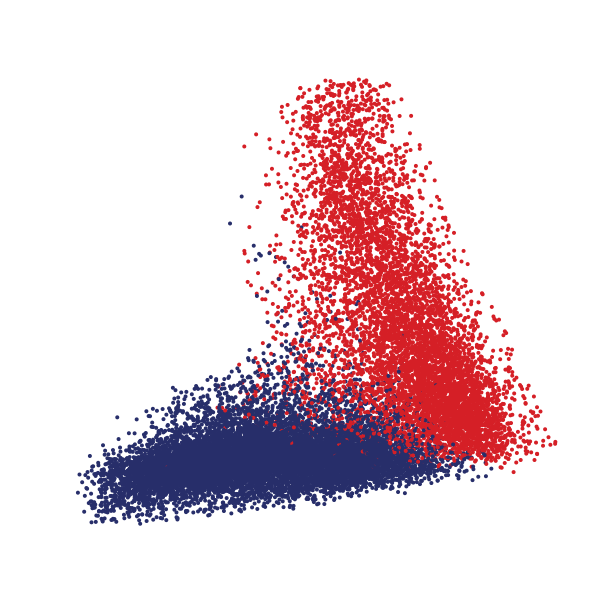

In [11]:
cols <- ArchR::paletteDiscrete(unique(coembed.sub$annotation))

p <- DimPlot(coembed.sub, reduction = "dm", cols = cols, 
              group.by = "annotation") +
    xlab("") + ylab("") + ggtitle("") +
    theme(axis.ticks = element_blank(),
         axis.text = element_blank(),
         axis.line = element_blank(),
         legend.position = "none")

options(repr.plot.height = 5, repr.plot.width = 5)

p

ggsave("fibroblast_dm_subclustering.pdf", plot=p, height = 5, width = 5)

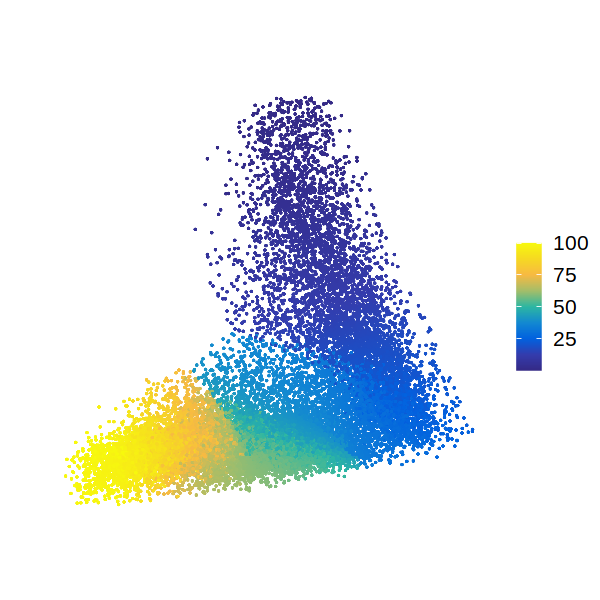

In [12]:
source("../../../../IntegrativeAnalysis/utils/trajectory_ArchR.R")

p <- plotTrajectoryA(coembed.sub, trajectory = "SCARA5_Myofib_dm", 
                      name = "SCARA5_Myofib_dm",
                      embedding = "dm", size = 1, 
                      plotAs = "points",
                      continuousSet = "blueYellow",
                     addArrow = FALSE) +
    xlab("") + ylab("") + ggtitle("") +
    theme_cowplot() +
    theme(axis.ticks = element_blank(),
         axis.text = element_blank(),
         axis.line = element_blank())

p

ggsave("fibroblast_dm_trajectory.pdf", plot=p, height = 5, width = 5)

In [13]:
## compute collagen score
## NABA geneset enrichment analysis
processNABA = function(filepath = './NABAgsets.xls') {
  con = file(filepath, 'r')
  naba_gsets = list()
  while ( TRUE ) {
    line = readLines(con, n = 1)
    if ( length(line) == 0 ) {
      break
    }
  split_line = unlist(strsplit(line, split = '\t'))
  naba_gsets[[split_line[1]]] = split_line[3:length(split_line)]
  }
  close(con)
  return(naba_gsets)
}

naba_gsets <- processNABA()

module_score <- lapply(c("NABA_COLLAGENS", "NABA_ECM_AFFILIATED",
             "NABA_ECM_GLYCOPROTEINS"), function(gset){
    genes <- list(intersect(rownames(coembed.sub), naba_gsets[[gset]]))

    ## add module score
    coembed.sub <- AddModuleScore(
      object = coembed.sub,
      features = genes,
    name = gset,
    assay = "RNA"
    )    

    score <- as.data.frame(coembed.sub@meta.data[, glue::glue('{gset}1')])
    colnames(score) <- gset
    rownames(score) <- rownames(coembed.sub@meta.data)
    
    score
}) %>% Reduce(cbind, .)

coembed.sub[["NABAModuleScore"]] <- CreateAssayObject(data = as.matrix(t(module_score)))
coembed.sub <- Seurat::ScaleData(coembed.sub, assay = "NABAModuleScore")

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Centering and scaling data matrix



Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



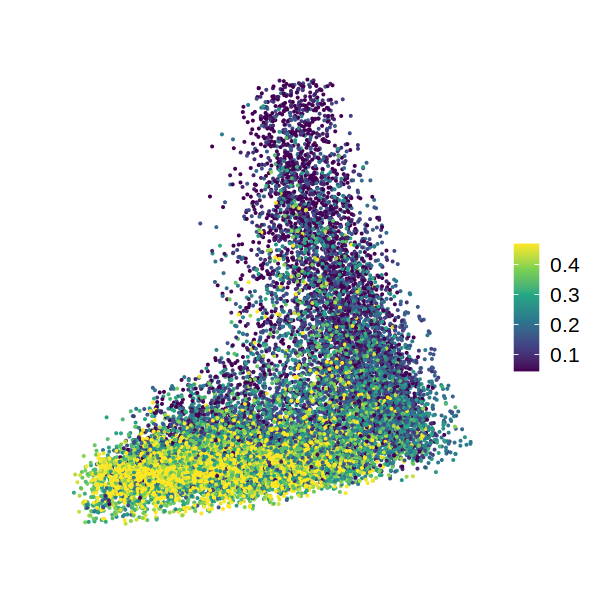

In [14]:
x.min <- min(coembed.sub@reductions$dm@cell.embeddings[, 1])
x.max <- max(coembed.sub@reductions$dm@cell.embeddings[, 1])
y.min <- min(coembed.sub@reductions$dm@cell.embeddings[, 2])
y.max <- max(coembed.sub@reductions$dm@cell.embeddings[, 2])

DefaultAssay(coembed.sub) <- "NABAModuleScore"

options(repr.plot.height = 5, repr.plot.width = 5)

p <- FeaturePlot(coembed.sub, features = "NABA-COLLAGENS", 
            reduction = "dm",
            min.cutoff = "q5", max.cutoff = "q90") + 
    scale_color_viridis_c()  +
    xlim(c(x.min, x.max)) + ylim(c(y.min, y.max)) +
        xlab("") + ylab("") + ggtitle("") +
        theme_cowplot() +
        theme(axis.ticks = element_blank(),
             axis.text = element_blank(),
             axis.line = element_blank())

p

ggsave("fibroblast_dm_ECM.pdf", plot=p, height = 5, width = 5)

`summarise()` has grouped output by 'patient_group'. You can override using the
`.groups` argument.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



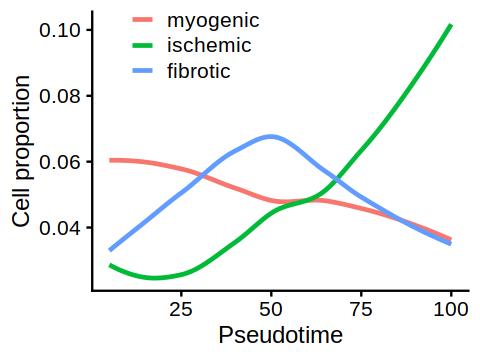

In [15]:
## cell proportion
p <- coembed.sub@meta.data %>%
    as.data.frame() %>%
    group_by(patient_group) %>%
    mutate(time_point = cut(SCARA5_Myofib_dm, 
                            breaks = seq(0, 100, 5), 
                            labels = seq(1, 20, 1))) %>%
    ungroup() %>%
    group_by(patient_group, time_point) %>%
    summarise(num_cells = n()) %>%
    mutate(cell_proportion = num_cells / sum(num_cells)) %>%
    mutate(time_point = 5*as.numeric(time_point)) %>%
    mutate(patient_group = stringr::str_replace_all(patient_group,
                                                   c("group_1" = "myogenic",
                                                    "group_2" = "ischemic",
                                                    "group_3" = "fibrotic"))) %>%
    mutate(patient_group = factor(patient_group, levels = c("myogenic",
                                                           "ischemic",
                                                           "fibrotic"))) %>%
    ggplot(aes(x = time_point, y = cell_proportion,
                                color = patient_group)) +
        geom_smooth(se = FALSE) +
    xlab("Pseudotime") + 
    ylab("Cell proportion") +
    theme_cowplot() +
        theme(legend.title = element_blank(),
             legend.position = c(0.1, 0.9))

options(repr.plot.height = 3, repr.plot.width = 4)

p

ggsave("fibroblast_human_cell_proportion.pdf", plot=p, height = 5, width = 5)

In [16]:
obj.mouse <- readRDS("../../../../IntegrativeAnalysis/Fibroblast/data/mouse_timecourse_snRNA/mouse_aggregation_v2_subclustered.cleaned.annotation.Rds")

In [17]:
obj.mouse@meta.data$cluster <- as.numeric(obj.mouse@meta.data[, 'leiden1.0'])
obj.mouse@meta.data$cluster <- stringr::str_replace_all(obj.mouse@meta.data$cluster,
                                                             c("9" = "8",
                                                              "10" = "9"))
## add annotation
new.cluster.ids <- c("1" = "Fib3",
               "2" = "Fib3",
               "4" = "Fib3",
               "6" = "Fib3",
                    "3" = "Fib1",
                    "5" = "Fib2",
                    "7" = "Fib2",
                    "8" = "Fib2",
                    "9" = "Fib2")

Idents(obj.mouse) <- "cluster"

obj.mouse <- RenameIdents(obj.mouse, new.cluster.ids)
obj.mouse$annotation <- Idents(obj.mouse)

obj.mouse$annotation <- factor(obj.mouse$annotation,
                              levels = c("Fib1", "Fib2", "Fib3"))

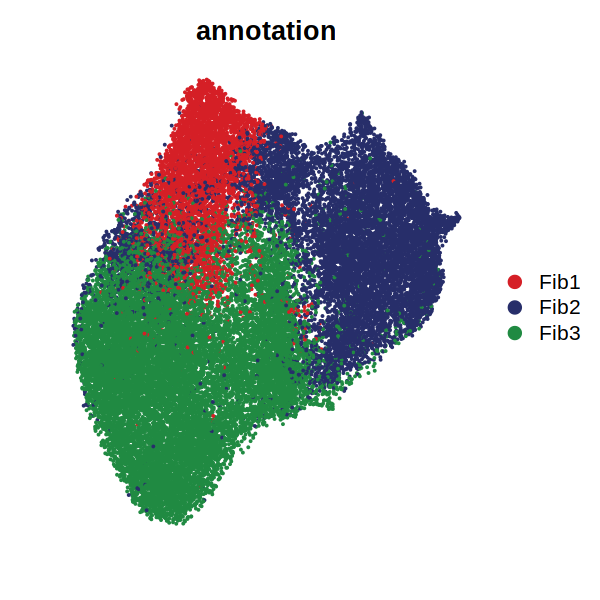

In [18]:
cols <- ArchR::paletteDiscrete(unique(obj.mouse$annotation))

p <- DimPlot(obj.mouse, group.by = "annotation", shuffle = TRUE,
             reduction = "umap_harmony", cols = cols) +
    xlab("") + ylab("") +
    theme(axis.line = element_blank(),
         axis.ticks = element_blank(),
         axis.text = element_blank())

options(repr.plot.height = 5, repr.plot.width = 5)

p

ggsave("mouse_umap_annotation.pdf", plot= p, height = 5, width = 5)

In [19]:
obj.mouse@meta.data$condition <- stringr::str_replace_all(obj.mouse@meta.data$condition,
                                               c("day_7a" = "Day 7",
                                                "day_14" = "Day 14",
                                                "day_4" = "Day 4",
                                                "sham" = "Sham"))
obj.mouse@meta.data$condition <- factor(obj.mouse@meta.data$condition, levels = c("Sham",
                                                             "Day 4",
                                                             "Day 7",
                                                             "Day 14"))

`summarise()` has grouped output by 'condition'. You can override using the
`.groups` argument.


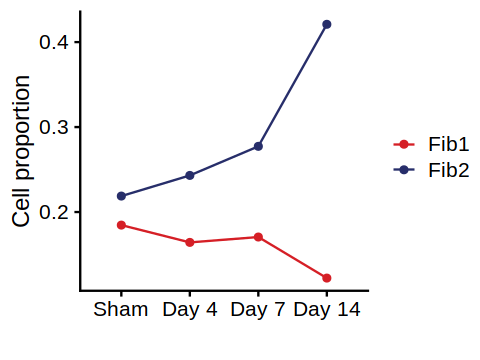

In [20]:
cols <- c("Fib1" = "#D51F26",
         "Fib2" = "#272E6A")

p <- obj.mouse@meta.data %>%
    as.data.frame() %>%
            group_by(condition, annotation) %>%
            summarise(counts = n()) %>%
            mutate(proportion = counts / sum(counts)) %>%
    subset(annotation != "Fib3") %>%
    ggplot(aes(x = condition, y = proportion, group = annotation,
                               color = annotation)) +
    geom_point() + 
    geom_line() + theme_cowplot() +
    scale_color_manual(values = cols) +
    xlab("") + ylab("Cell proportion") +
    theme(legend.title = element_blank())

options(repr.plot.height = 3, repr.plot.width = 4)

p

ggsave("mouse_cell_proportion.pdf", plot= p, height = 3, width = 4)

In [21]:
## plot GRN
df <- read.csv("../../../../IntegrativeAnalysis/Fibroblast/data/snATAC_SCARA5_Myofib/gene_regulatory_network.csv")

tf.list <- unique(df$tf)
gene.list <- setdiff(unique(df$gene), tf.list)


df_measure <- read.csv("../../../../IntegrativeAnalysis/Fibroblast/data/snATAC_SCARA5_Myofib/netmeasures_final_fibroblast.csv",
                      row.names = 1) %>%
    subset(., type == "TF/Gene") %>%
    select(c(name, page, bet)) %>%
    mutate(page_scale = scale(page)[, 1]) %>%
    mutate(bet_scale = scale(bet)[, 1]) %>%
    rename(tf = name)

## compute importance only for TFs based on centrality and betweenness
min.page <- min(df_measure$page_scale)
min.bet <- min(df_measure$bet_scale)
df_measure$importance <- sqrt((df_measure$page_scale - min.page)**2 + 
                             (df_measure$bet_scale - min.bet)**2)
df_measure <- df_measure[order(-df_measure$importance), ]
rownames(df_measure) <- df_measure$tf


## load clustering results for genes and pseudotime point for TFs
df_gene_clustering <- read.csv("../../../../IntegrativeAnalysis/Fibroblast/data/snATAC_SCARA5_Myofib/gene_cluster.csv",
                         row.names = 1) %>%
    mutate(gene = stringr::str_split_fixed(gene, ":", 2)[, 2]) %>%
    subset(gene %in% gene.list)

df_timepoint <- read.csv("../../../../IntegrativeAnalysis/Fibroblast/data/snATAC_SCARA5_Myofib/TF_time_point.csv",
                        row.names = 1) %>%
    mutate(tf = matchname1) %>%
     subset(tf %in% tf.list)

# create graph from data frame
g <- graph_from_data_frame(df, directed=TRUE)

# assign size to each node
## for TFs, the size is proportional to the importance
tf_size <- df_measure$importance

## for genes, we use the minimum size of TFs
gene_size <- rep(min(df_measure$importance), length(gene.list))

names(tf_size) <- df_measure$tf
names(gene_size) <- gene.list

v_size <- c(tf_size, gene_size)

# add size
V(g)$size <- v_size[V(g)$name]

# assign color to each node
## TFs are colored by pseudotime point
df_timepoint <- df_timepoint[order(df_timepoint$time_point), ]

tf_color <- ArchR::paletteContinuous(set = "blueYellow", 
                                     n = nrow(df_timepoint))
names(tf_color) <- df_timepoint$tf

## genes are colored based on the clustering
gene_color <- stringr::str_replace_all(df_gene_clustering$cluster,
                                      c("late_stage" = "#272E6A",
                                       "early_stage" = "#D51F26"))

names(gene_color) <- df_gene_clustering$gene

v_color <- c(tf_color, gene_color)

## assign alpha
tf_alpha <- rep(1, length(tf.list))
gene_alpha <- rep(0.5, length(gene.list))

names(tf_alpha) <- tf.list
names(gene_alpha) <- gene.list

v_alpha <- c(tf.list, gene.list)

V(g)$alpha <- v_alpha[V(g)$name]

# compute layout
set.seed(42)
layout <- layout_with_fr(g, weights = E(g)$correlation, dim = 2, niter = 1000)

Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Using alpha for a discrete variable is not advised.”


png 
  2

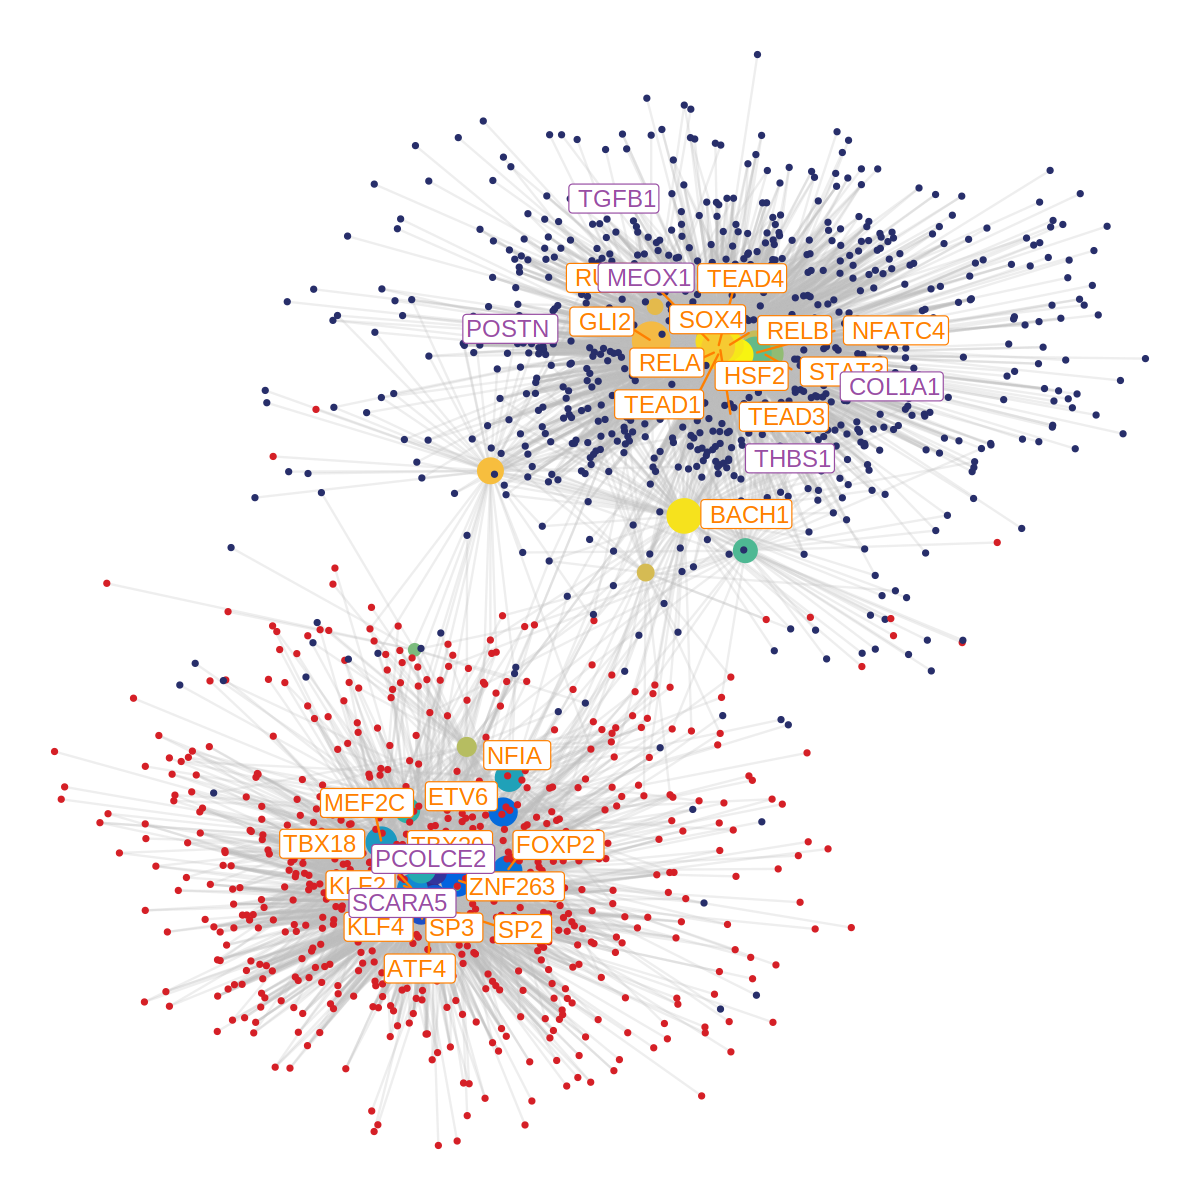

In [32]:
options(repr.plot.height = 10, repr.plot.width = 10)

df_measure_sub <- subset(df_measure, importance > 2)

p <- ggraph(g, layout = layout) +
geom_edge_link(edge_colour = "gray", edge_alpha = 0.25) +
geom_node_point(aes(size = V(g)$size,
                   color = as.factor(name),
                   alpha = V(g)$alpha,
                   ),
                show.legend = FALSE) +
    scale_size(range = c(1, 10)) +
    scale_color_manual(values = v_color) +
geom_node_label(aes(filter = V(g)$name %in% df_measure_sub$tf,
                    label = V(g)$name),
                    repel = TRUE,
                    hjust = "inward",
                color = "#ff7f00",
                size = 5,
                show.legend = FALSE,
               max.overlaps = Inf) +
geom_node_label(aes(filter = V(g)$name %in% c("SCARA5", "PCOLCE2",
                                             "MBLN1", "COL1A1", "POSTN",
                                             "TGFB1", "THBS1", "MEOX1") ,
                    label = V(g)$name),
                    repel = TRUE,
                    hjust = "inward",
                size = 5,
                color = "#984ea3",
                show.legend = FALSE) +
 theme_void()


options(repr.plot.height = 10, repr.plot.width = 10)

print(p)

pdf("gene_regulatory_network.pdf", height = 10, width = 10)
print(p)
dev.off()

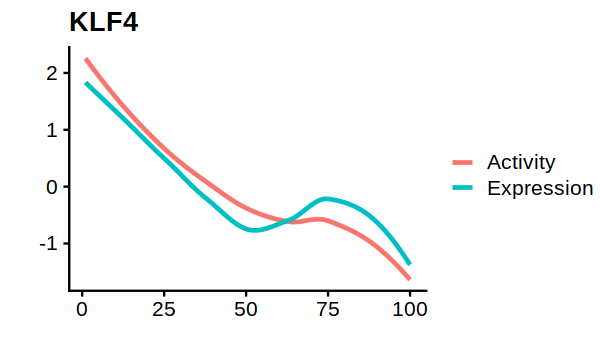

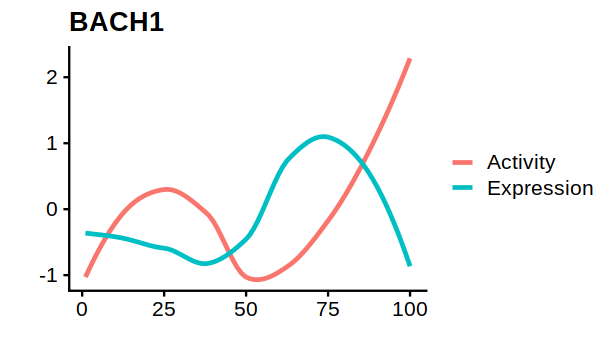

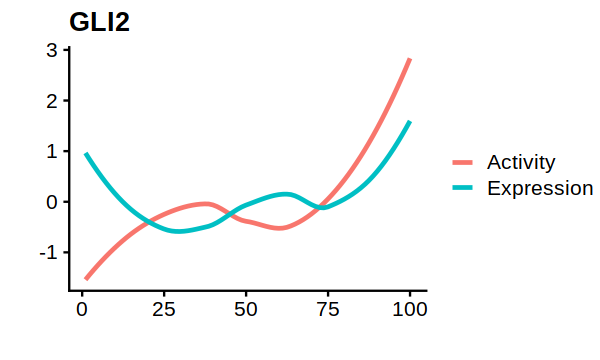

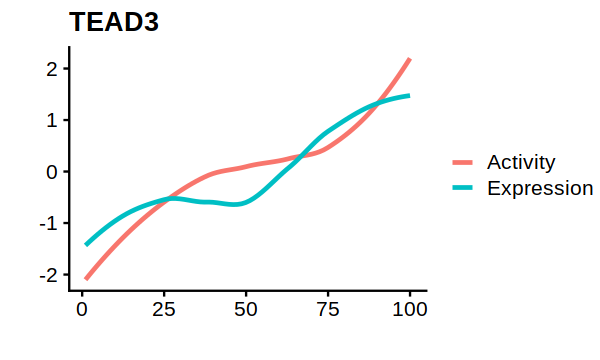

In [31]:
## plot regulators
df_activity <- read.csv("../../../../IntegrativeAnalysis/Fibroblast/data/snATAC_SCARA5_Myofib/VisGRN_V2/TF_activity.csv")
df_expression <- read.csv("../../../../IntegrativeAnalysis/Fibroblast/data/snATAC_SCARA5_Myofib/VisGRN_V2/TF_expression.csv")

options(repr.plot.height = 3, repr.plot.width = 5)

for(sel_tf in c("KLF4", "BACH1", "GLI2", "TEAD3")){
        df_plot1 <- subset(df_activity, tf == sel_tf) %>%
            rename(value = tf_activity) %>%
            mutate(value = scale(value)) %>%
            mutate(data = "Activity")

        
        df_plot2 <- subset(df_expression, tf == sel_tf) %>%
            rename(value = tf_expression)%>%
            mutate(value = scale(value)) %>%
            mutate(data = "Expression")
        
        df_plot <- rbind(df_plot1, df_plot2)
        
        p <- ggplot(data = df_plot, aes(x = pseudotime, y = value, color = data)) +
        geom_smooth(formula = y ~ x, method = "loess",se = FALSE) +
        xlab("") + ylab("") +
        theme_cowplot() + ggtitle(sel_tf) +
        theme(legend.title = element_blank())
    
        print(p)
    
    ggsave(glue::glue("{sel_tf}.pdf"), plot = p, height = 3, width = 5)
        
}

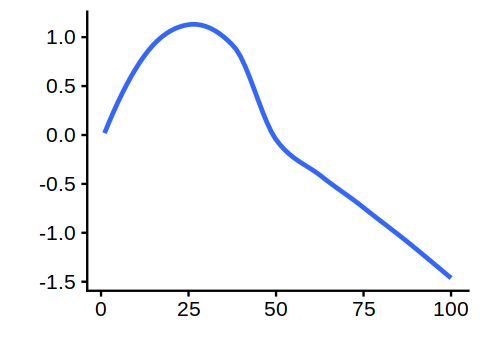

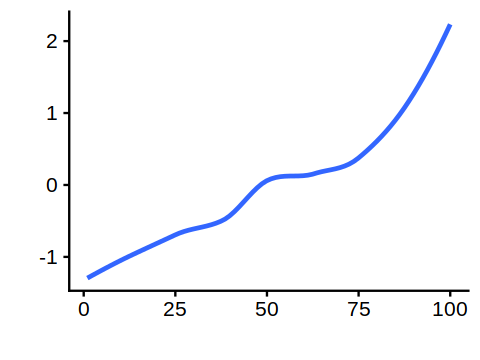

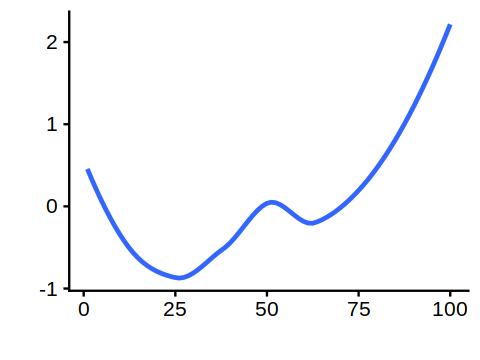

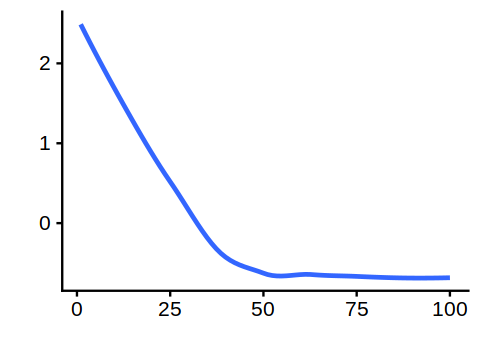

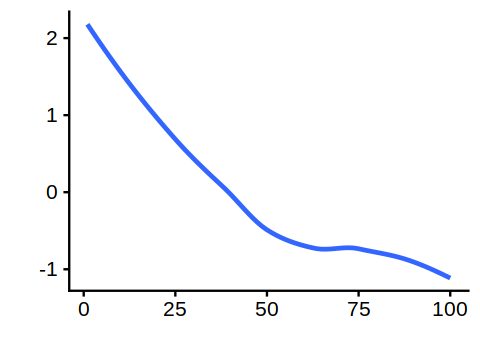

In [30]:
## target gene expression
df <- read.csv("../../../../IntegrativeAnalysis/Fibroblast/data/snATAC_SCARA5_Myofib/VisGRN_V2/TF_Target_Gene_expression.csv",
              row.names = 1)

options(repr.plot.height = 3, repr.plot.width = 4)

for(sel_gene in c("MBNL1","THBS1", "TGFB1", "SCARA5", "PCOLCE2")){
    p <- df %>%
        subset(gene == sel_gene) %>%
        ggplot(aes(x = pseudotime, y = gene_expression)) +
        geom_smooth(formula = y ~ x, method = "loess",se = FALSE) +
        xlab("") + ylab("") +
        theme_cowplot() +
        theme(legend.title = element_blank())
    
    print(p)
    
    ggsave(glue::glue("{sel_gene}.pdf"), plot = p, height = 3, width = 4)

}

In [4]:
## plot myeloid
coembed <- readRDS("../../../../IntegrativeAnalysis/Myeloid/data/coembed/coembed.annotation.Rds")
coembed

An object of class Seurat 
131519 features across 17533 samples within 3 assays 
Active assay: RNA (28933 features, 2000 variable features)
 2 other assays present: peaks, GeneActivity
 5 dimensional reductions calculated: pca, umap, harmony, umap_harmony, umap_harmony_v2

In [5]:
df_count <- coembed@meta.data %>%
    as.data.frame() %>%
    group_by(annotation, tech) %>%
    summarise(count = n())

df_count

write.csv(df_count, "df_count_myeloid.csv")

`summarise()` has grouped output by 'annotation'. You can override using the
`.groups` argument.


annotation,tech,count
<fct>,<chr>,<int>
LYVE_FOLR_Macrophages,ATAC,877
LYVE_FOLR_Macrophages,RNA,4563
LYVE_PLTP_Macrophages,ATAC,815
LYVE_PLTP_Macrophages,RNA,2902
Monocytes,ATAC,518
Monocytes,RNA,2647
SPP1_Macrophages,ATAC,680
SPP1_Macrophages,RNA,2087
CCL18_Macrophages,ATAC,550


In [2]:
cols <- ArchR::paletteDiscrete(unique(coembed$annotation))

cols

p <- DimPlot(coembed, reduction = "umap_harmony_v2", group.by = "annotation",
             cols = cols) +
    xlab("") + ylab("") + ggtitle("") +
    theme(axis.ticks = element_blank(),
         axis.text = element_blank(),
         axis.line = element_blank())

options(repr.plot.width = 7, repr.plot.height = 5)

p

ggsave("myeloid_umap_subclustering.pdf", plot=p, height = 5, width = 7)

LYVE_FOLR_Macrophages LYVE_PLTP_Macrophages             Monocytes 
            "#D51F26"             "#272E6A"             "#208A42" 
     SPP1_Macrophages     CCL18_Macrophages 
            "#89288F"             "#F47D2B"

ERROR: Error in DimPlot(coembed, reduction = "umap_harmony_v2", group.by = "annotation", : could not find function "DimPlot"


png 
  2

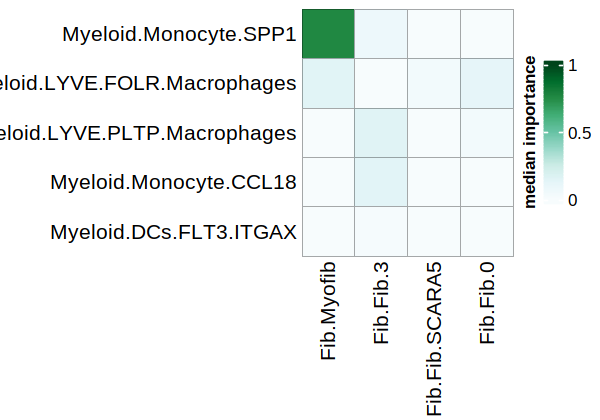

In [2]:
suppressMessages(library(circlize))
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(textshape))
suppressMessages(library(tidyr))

## misty results
df <- read.csv("../FibMyeloid_mistypanels/summarized_importances.csv") %>%
    subset(Predictor %in% c("Myeloid.DCs.FLT3.ITGAX",
                        "Myeloid.LYVE.FOLR.Macrophages",
                        "Myeloid.LYVE.PLTP.Macrophages",
                        "Myeloid.Monocyte.CCL18",
                        "Myeloid.Monocyte.SPP1")) %>%
    #subset(view == "intra_pred")
    subset(view == "para_pred_5") %>%
    dplyr::select(c(Target, Predictor, median_imp)) %>%
    pivot_wider(names_from = Target, values_from = median_imp, values_fill = 0) %>%
    column_to_rownames('Predictor')


col_fun <- colorRamp2(seq(from = 0, to = 1, length = 9), 
                     RColorBrewer::brewer.pal(name = "BuGn", n = 9))

ht <- Heatmap(as.matrix(df), 
               name = "median importance",
               cluster_columns = TRUE,
              cluster_rows = TRUE,
              show_row_dend = FALSE,
              show_column_dend = FALSE,
               rect_gp = gpar(col = "black", lwd = 0.2),
               heatmap_legend_param = list(
                title = "median importance",
               title_position = "leftcenter-rot",
               legend_height = unit(3, "cm")),
              col = col_fun,
              na_col = "white",
             row_names_side = "left"
                 )
options(repr.plot.height = 3.5, repr.plot.width = 5)
draw(ht)

pdf("misty_para_pred_5.pdf", height = 3.5, width = 5)
draw(ht)
dev.off()